In [2]:
# importing literature
import numpy as np

from pandas.tseries import *
from pandas_datareader.data import DataReader
from pandas_datareader import data
import pandas as pd

import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

import cvxopt as opt
from cvxopt import blas, solvers
import scipy.optimize as sco
import seaborn as sns

plt.style.use('fivethirtyeight')
np.random.seed(777)

# all data are in the first differeance 
data = pd.read_excel('dataforJan.xlsx')
data.set_index(data['Date'], inplace=True)

data.set_index('Date', inplace=True)

assets = ["Gold return", "Oil retur", "US bond yield" ,"S&P", "JP bond yield", "Nikkei", "jpy/usd return" ,"GR 10-Y Bond Yield", " DAX",  " eur/usd", "Shanghai Composite" , "China 3-Year Bond Yield"]

In [5]:
#calculation of historical means 
mean_returns = data.mean()

# calculation of covariance 
cov_matrix = data.cov()

#number of runs of random portfolio weights
num_portfolios = 1000000
#US one month T-bond yield
risk_free_rate = 0.0146

In [6]:
#mean-variance optimization and efficient Frontier short selling constraint

def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) 
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in xrange(num_portfolios):
        weights = np.random.random(12)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [7]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,3)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,3)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    
    print "-"*80
    print "Maximum Sharpe Ratio Portfolio Allocation\n"
    print "Return:", round(rp,3)
    print "Volatility:", round(sdp,3)
    print "\n"
    print max_sharpe_allocation
    print "-"*80
    print "Minimum Volatility Portfolio Allocation\n"
    print "Return:", round(rp_min,3)
    print "Volatility:", round(sdp_min,3)
    print "\n"
    print min_vol_allocation
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='b',s=500, label='Minimum volatility')
    plt.title('Portfolio Optimization and Efficient Frontier')
    plt.xlabel('volatility')
    plt.ylabel('returns')
    plt.legend(labelspacing=0.8)
    plt.savefig('1.png', dpi=199)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Return: 0.031
Volatility: 0.091


            Gold return  Oil return  US bond yield    S&P  JP bond yield  \
allocation         2.47       5.411          0.585  0.289          0.038   

            Nikkei  jpy/usd return  GR 10-Y Bond Yield     DAX  eur/usd  \
allocation   4.805           0.361               1.818  46.442    0.562   

            Shanghai Composite  China 3-Year Bond Yield   
allocation                0.31                    36.909  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Return: 0.004
Volatility: 0.02


            Gold return  Oil return  US bond yield    S&P  JP bond yield  \
allocation       21.426       1.505          5.773  10.68          1.751   

            Nikkei  jpy/usd return  GR 10-Y Bond Yield    DAX  eur/usd  \
allocation   6.417          20.772    

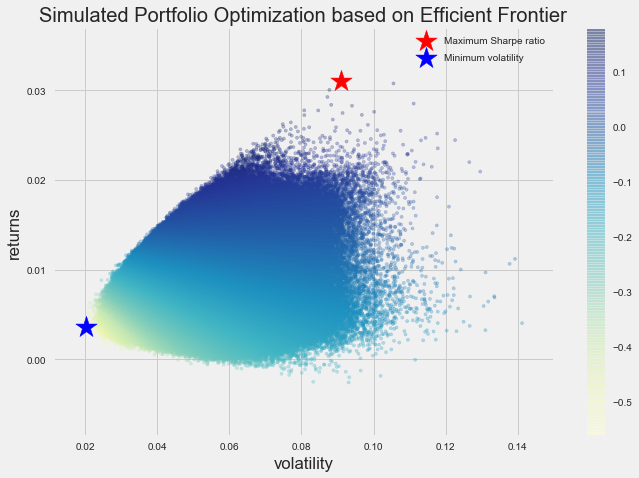

In [19]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [8]:
#mean-variance optimization and efficient Frontier no constraint

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (-1.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [9]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (-1.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [10]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((-1,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [11]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,3)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,3)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print "-"*80
    print "Maximum Sharpe Ratio Portfolio Allocation\n"
    print "Return:", round(rp,3)
    print "Volatility:", round(sdp,3)
    print "\n"
    print max_sharpe_allocation
    print "-"*80
    print "Minimum Volatility Portfolio Allocation\n"
    print "Return:", round(rp_min,3)
    print "Volatility:", round(sdp_min,3)
    print "\n"
    print min_vol_allocation
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='b',s=500, label='Minimum volatility')
    
    target = np.linspace(rp_min, 0.1, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('volatility')
    plt.ylabel('returns')
    plt.legend(labelspacing=0.8)
    plt.savefig('his.png', dpi=199)
    
    historical_porfolio = pd.ExcelWriter('Historical_portfolio.xlsx', engine='xlsxwriter')
   
    max_sharpe_allocation.to_excel(historical_porfolio, 'Sheet1')
    min_vol_allocation.to_excel(historical_porfolio, 'Sheet2') 
    historical_porfolio.save()

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Return: 0.094
Volatility: 0.251


            Gold return  Oil return  US bond yield    S&P  JP bond yield  \
allocation        100.0      27.521        -19.097  29.04          7.559   

            Nikkei  jpy/usd return  GR 10-Y Bond Yield     DAX  eur/usd  \
allocation    -4.0          -100.0             -15.253  73.083   -100.0   

            Shanghai Composite  China 3-Year Bond Yield   
allocation               1.146                     100.0  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Return: 0.002
Volatility: 0.015


            Gold return  Oil return  US bond yield    S&P  JP bond yield  \
allocation       14.225      -4.024          3.441  8.105         -0.009   

            Nikkei  jpy/usd return  GR 10-Y Bond Yield    DAX  eur/usd  \
allocation    5.85          45.477   

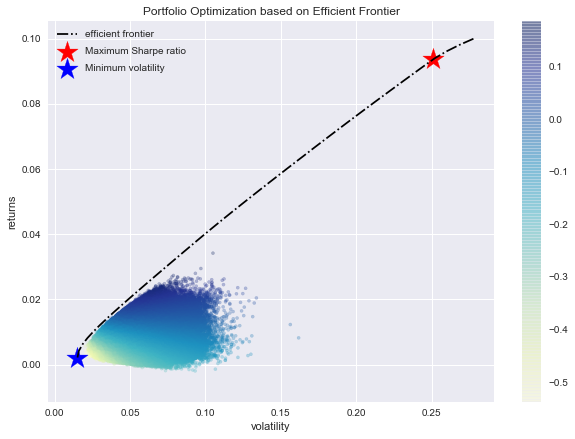

In [12]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)